# מודל לחיזוי סיכוני הלוואות

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## במערך נתונים זה, כל רשומה מייצגת אדם שלוקח הלוואה על ידי בנק. כל אדם מסווג כסיכוני הלוואה טובים או רעים לפי מערך התכונות.

In [2]:
data = pd.read_csv("datasets_531_1056_german_credit_data.csv")

In [3]:
data

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,996,40,male,3,own,little,little,3857,30,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
998,998,23,male,2,free,little,little,1845,45,radio/TV


In [4]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


In [5]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [6]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## ניתוח נתונים

להלן אגדיר פונקציה שתייצר גרפים לשלושה משתנים מספריים לפי עמודה קטגורית שנבחרה.

In [7]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

### משתנים מספריים לפי מין

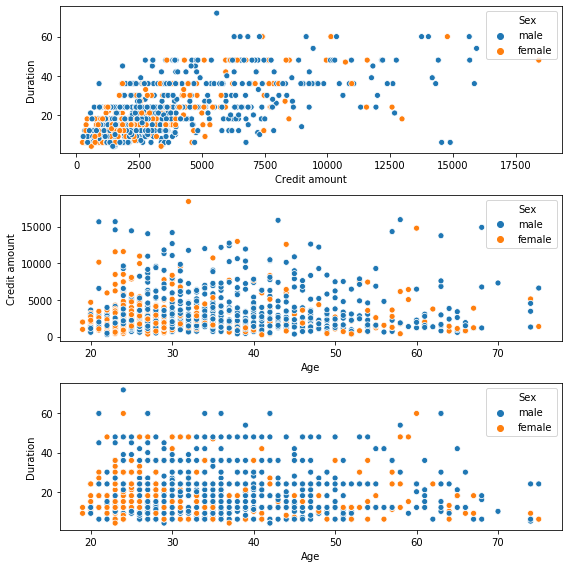

In [8]:
scatters(data, h="Sex")

הרושם הכללי הוא שנשים נוטות להיות צעירות מגברים, אולם בגרף העליון מראה כי אין הבדל ברור בין גברים לנשים מבחינת סכום ההלוואה ומשך הזמן. מבדיקה חזותית נראה שיש קשר חיובי כלשהו בין משך לסכום ההלוואה.

### נבדוק את המתאם הליניארי בין סכום ההלוואה למשך הזמן

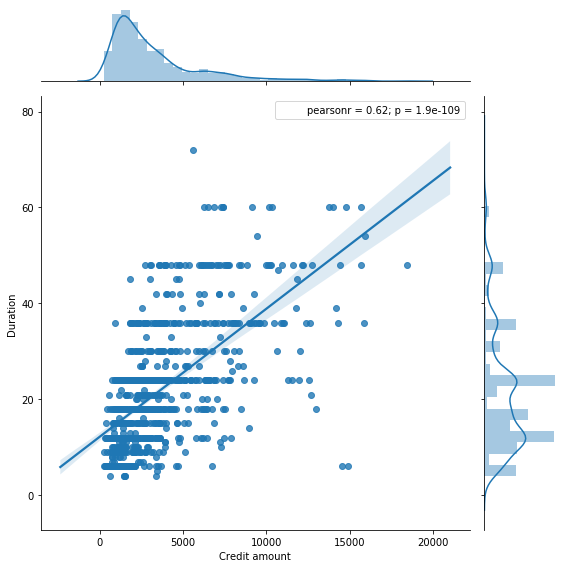

In [9]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=data, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

הגרף למעלה מציגה מתאם ליניארי עם ערך פירסון של 0.62 וערך p קטן מאוד. זה הגיוני מכיוון שבדרך כלל אנשים לוקחים הלוואות גדולות יותר לתקופות ארוכות יותר.

### להלן גרף רגרסיה לינאריות עם קטגוריות שונות

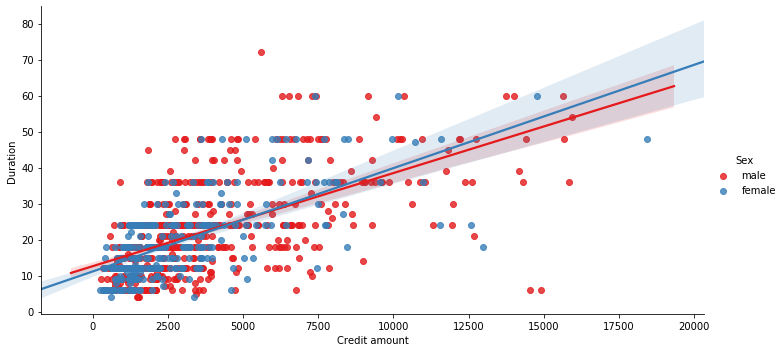

In [10]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

לגרף מצביעה על כך שאין הבדל משמעותי בין גברים לנשים.

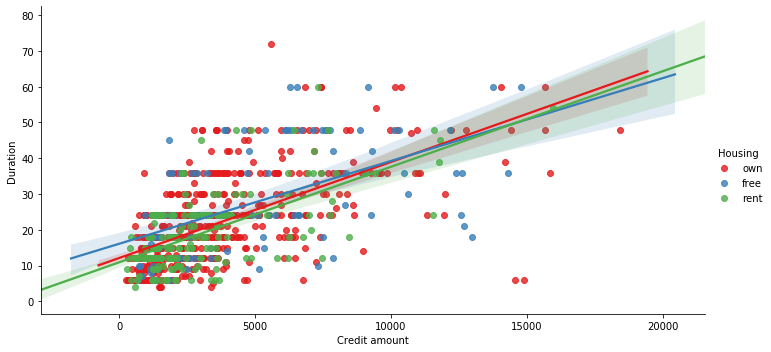

In [11]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

ניתן לראות באופן דומה כי אין הבדל בין קטגוריות הדיור.

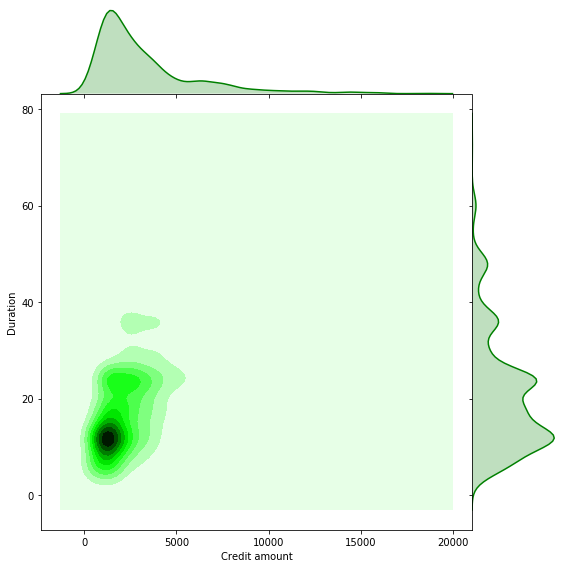

In [12]:
sns.jointplot("Credit amount","Duration", data=data, kind="kde", space=0, color="g",  height=8)
plt.show()

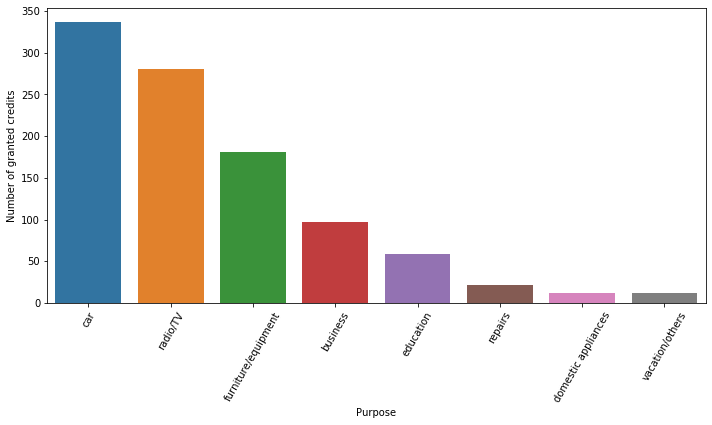

In [13]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

הגרך שלמעלה מראה כמה הלוואות הוענקו למטרות שונות. מרבית ההלוואות הוענקו לרכב ולרדיו / טלוויזיה.

In [14]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

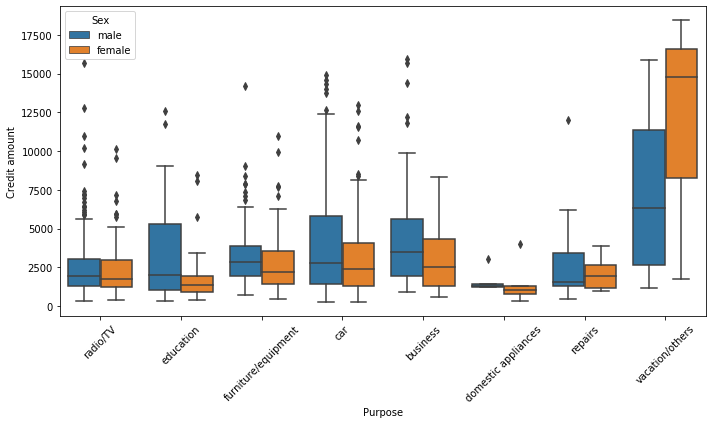

In [15]:
boxes("Purpose","Credit amount","Sex")

מהגרף עולה כי הסכומים הגדולים ביותר נלקחים לחופשות / אחרות, הקטנות ביותר עבור מכשירי חשמל ביתיים. לרובם יש outliers בצד העליון של התיבות (כמויות גבוהות יותר). ברוב המקרים אין הבדל בין גברים לנשים, למרות חופשה בקטגוריה / אחרות. אך יש לזכור כי הוענק סכום נמוך של הלוואות בקטגוריה זו.

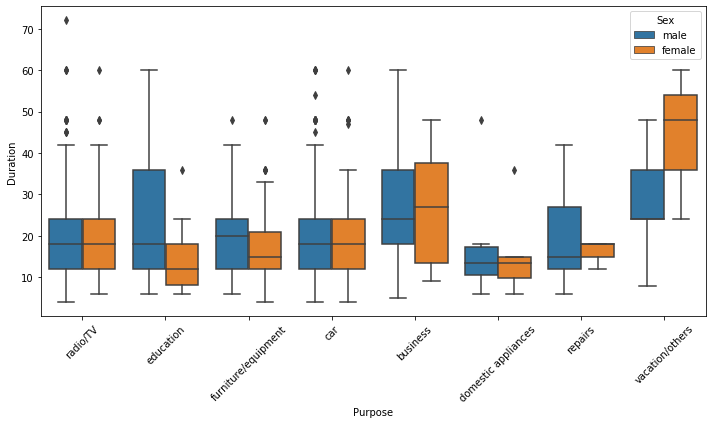

In [16]:
boxes("Purpose","Duration","Sex")

הגרף מצביע על כך שבאופן כללי אין הבדל במשך הלוואה בין גברים ונשים. אנחנו לא יכולים לראות מגמה ברורה בין קטגוריות עם תצפיות שהמשך הקצר ביותר הוא עבור מכשירי חשמל ביתיים. זה הגיוני כפי שהוא בהסכמה עם תובנות מהתרשים הקודם (סכום ההלוואה) - בקטגוריה זו, יש את הסכומים הנמוכים ביותר.

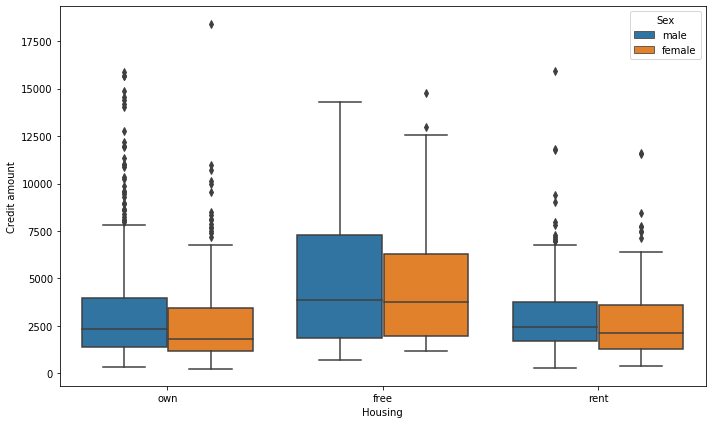

In [17]:
boxes("Housing","Credit amount","Sex",r=0)

מבחינת קטגוריית הדיור, אין הבדל גדול למרות שאנשים שיש להם דיור "בחינם" נוטים לקחת הלוואות מעט גדולים יותר.

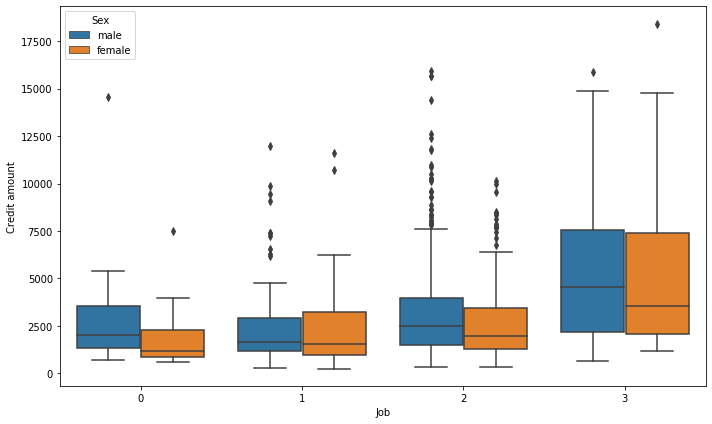

In [18]:
boxes("Job","Credit amount","Sex",r=0)

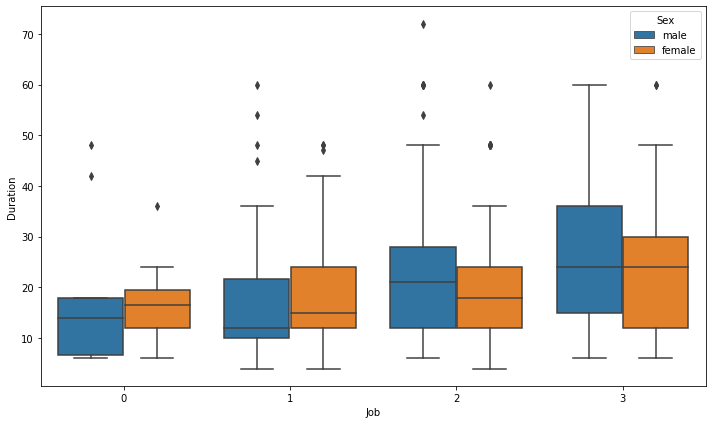

In [19]:
boxes("Job","Duration","Sex",r=0)

מבחינת קטגוריית התפקיד שוב אין הבדל בין גברים לנשים, אך אנו יכולים לראות שקטגוריית משרות 3 נוטה לקחת סכומי הלוואות גדולים יותר למשך זמן רב יותר.

Text(0.5, 0, 'Age')

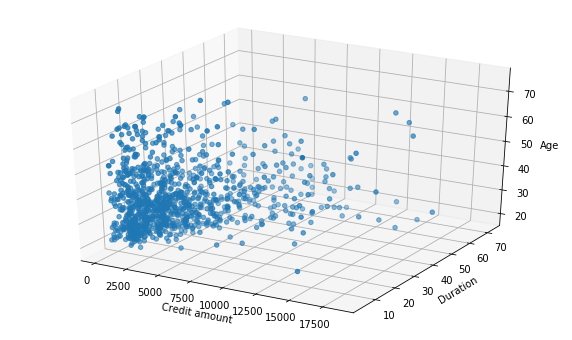

In [20]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

## מודל לחיזוי

**Clustering with KMeans**

In [21]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

In [22]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

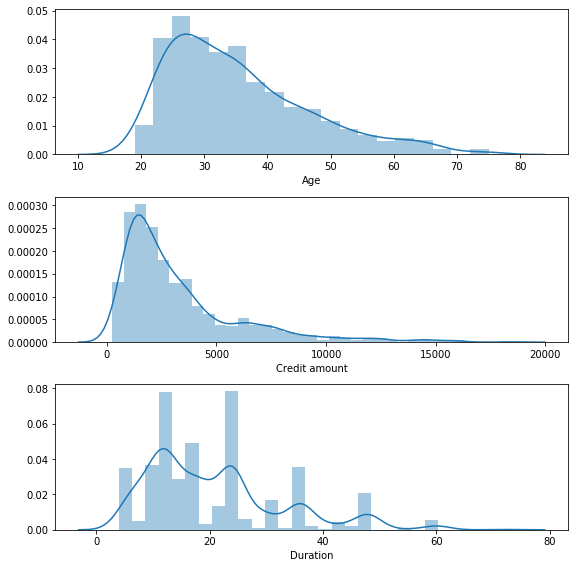

In [23]:
distributions(cluster_data)

אנו יכולים לראות ההתפלגות מוטת ימינה. כדי להשיג תוצאות טובות יותר עלינו להסיר את השיפוע על ידי טרנספורמציה לוגריתמית.

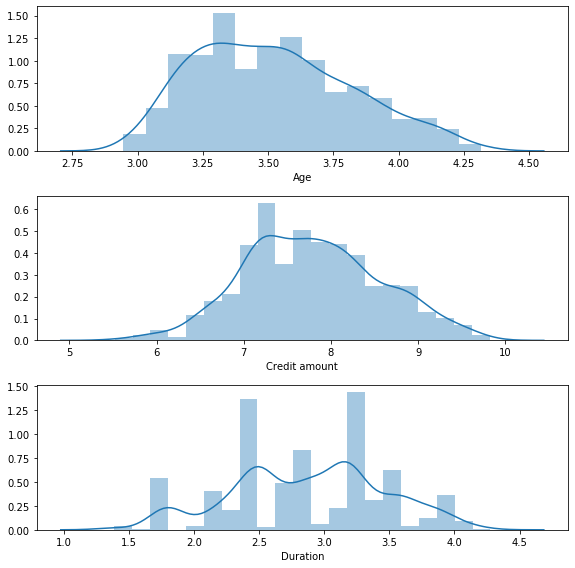

In [24]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

In [25]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

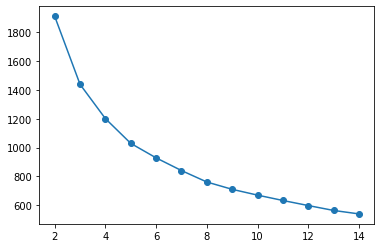

In [26]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

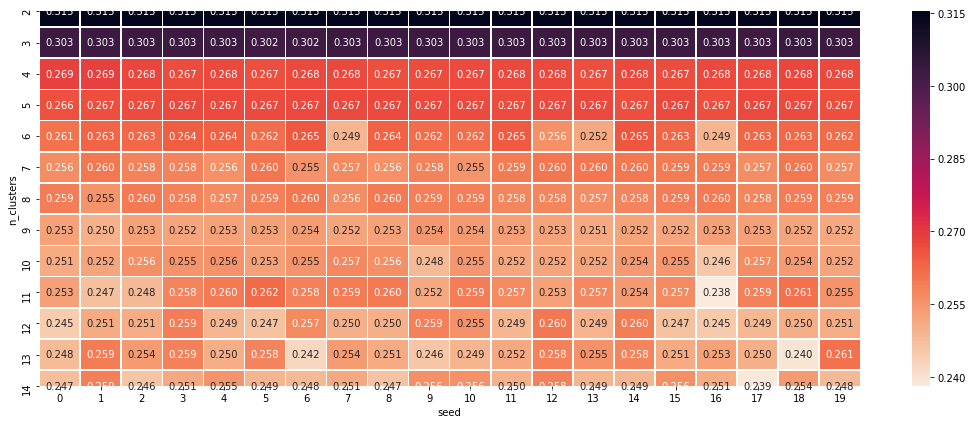

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

מפת החום למעלה מציגה ציונים לשילובים שונים של מצב אקראי ומספר שדות. הציון הגבוה ביותר הוא עבור שדות 2 ו -3 והם יחסית לא רגישים לשדות.

אבחר 3 שדות כדי לקבל יותר תובנה לגבי נתונים.

In [28]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

להלן אצור גרף צלליות לשלושה שדות על מנת לתאר חזותית את ההתאמה של כל נקודה בתוך השדה שלו

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30318933408774545


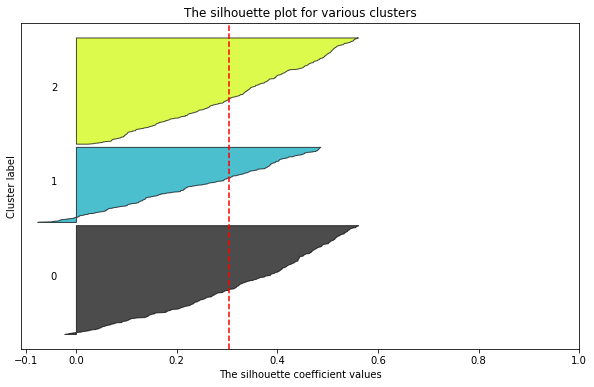

In [29]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

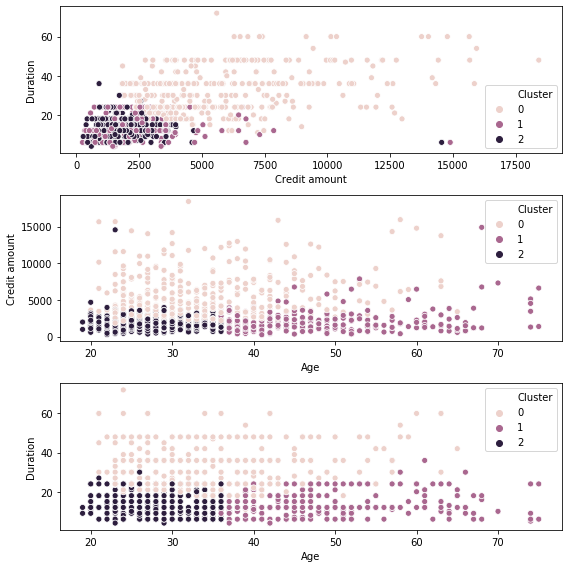

In [30]:
scatters(clustered_data, 'Cluster')

In [31]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


שדה 0 - הממוצע התחתון של סכום ההלוואה, משך זמן קצר, לקוחות מבוגרים

שדה 1 - הממוצע הגבוה של סכום ההלוואה, משך זמן ארוך, לקוחות בגיל העמידה

שדה 2 - הממוצע התחתון של סכום ההלוואה, משך זמן קצר, לקוחות צעירים

**Clustering with Affinity Propagation**

באלגוריתם זה ישנם שני פרמטרים רלוונטיים: העדפה והטלה. זה אומר שאנחנו לא מגדירים את מספר השדות המקדימים. 

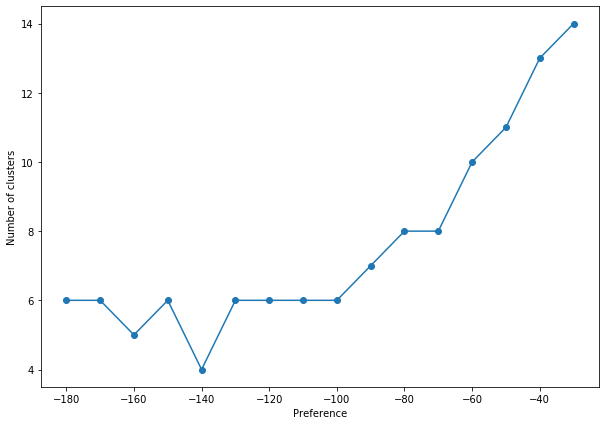

In [32]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')


יחד עם ירידה בערך ההעדפה מספר הפרמטרים של השדות יורד וגם רמות לערכי העדפה קטנים מאוד. אני אבדוק אפשרות של ארבעה שדות.

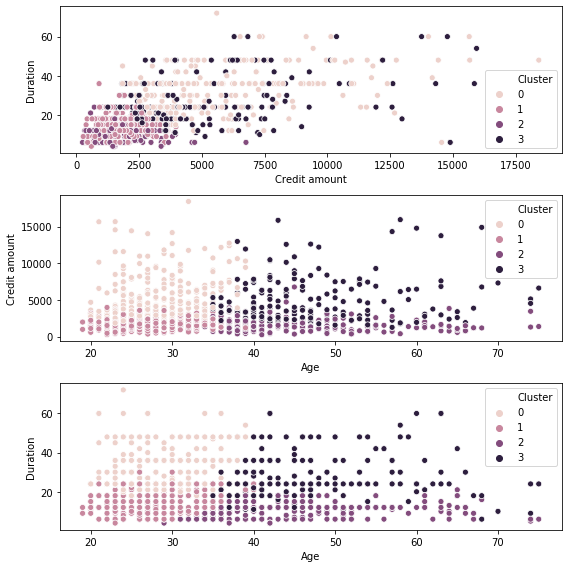

In [33]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)


In [34]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


אשכול 0 - הממוצע הגבוה של סכום ההלוואה, משך זמן ארוך, לקוחות צעירים יותר

אשכול 1 - הממוצע הנמוך של סכום ההלוואה, משך זמן קצר, לקוחות צעירים יותר

אשכול 2 - ממוצע נמוך של סכום ההלוואה, משך זמן קצר, לקוחות מבוגרים

אשכול 3 - הממוצע הגבוה של סכום ההלוואה, משך זמן ביניים, לקוחות מבוגרים